In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Load Train and Validation Data

# Load the train data
train_url = "https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Train.csv"
train_df = pd.read_csv(train_url)

# Load the validation data
val_url = "https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Val.csv"
val_df = pd.read_csv(val_url)



In [28]:
# View Train Data
train_df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [29]:
val_df.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


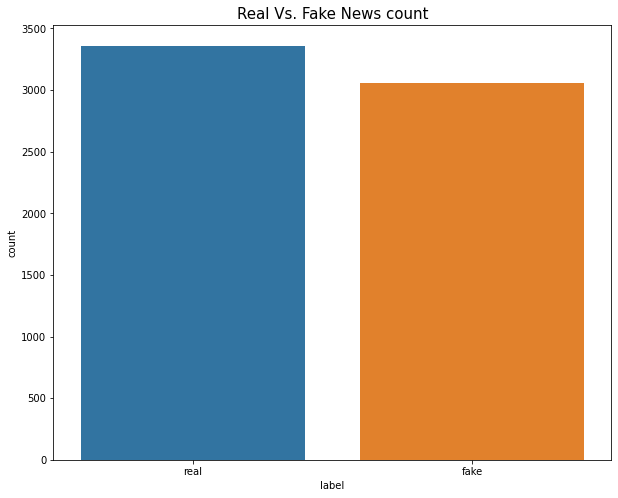

In [30]:
# Evaluate whether the data is balanced or not
plt.figure(figsize = (10,8))
sns.countplot(train_df['label'])
plt.title("Real Vs. Fake News count", fontsize = 15)
plt.show()

In [31]:
# Upsample Fake News to Balance the Dataset
from sklearn.utils import resample

df_majority = train_df[train_df.label =='real']
df_minority = train_df[train_df.label == 'fake']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])
df_upsampled

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
5,6,"Covid Act Now found ""on average each person in...",real
...,...,...,...
3701,3702,"Trudeau airs a coronavirus update rerun, to se...",fake
2486,2487,Trumps nude statue is made in New York city be...,fake
5469,5470,Says Russia unleashed more than 500 lions on i...,fake
1982,1983,Hospital in Pakistan is overwhelmed by COVID-1...,fake


In [32]:
## Validating that dataset is balanced after upsampling
print("Real News Dataset Size: " + str(df_majority.shape))
print("Fake News Dataset Size Before Upsampling: " + str(df_minority.shape))
print("Fake News Dataset Size After Upsampling: " + str(negative_upsample.shape))

Real News Dataset Size: (3360, 3)
Fake News Dataset Size Before Upsampling: (3060, 3)
Fake News Dataset Size After Upsampling: (3360, 3)


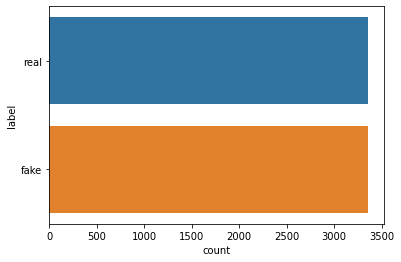

In [33]:
sns.countplot(y="label", data = df_upsampled);

In [34]:
## Check if validation set size
len(val_df)

2140

In [35]:
## Split train and test, drop id column, and binarize target
x_train = df_upsampled
x_val = val_df
y_train = df_upsampled[['label']].to_numpy()
y_val = val_df[['label']].to_numpy()
from sklearn import preprocessing
y_train= preprocessing.label_binarize(y_train, classes =['real', 'fake'])
y_val = preprocessing.label_binarize(y_val, classes=['real', 'fake'])


In [36]:
x_train

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
5,6,"Covid Act Now found ""on average each person in...",real
...,...,...,...
3701,3702,"Trudeau airs a coronavirus update rerun, to se...",fake
2486,2487,Trumps nude statue is made in New York city be...,fake
5469,5470,Says Russia unleashed more than 500 lions on i...,fake
1982,1983,Hospital in Pakistan is overwhelmed by COVID-1...,fake


In [37]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

## Preprocessing Methods

In [38]:
# Download stopwords and its dependencies for preprocessing
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
wn = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
pip install cleantext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
# Pre-Processed News Dataset 1
# 1. set reviews to lowercase
# 2. remove urls
# 3. remove stopwords
# 4. remove punctuation
# 5. lemmatize words

from string import punctuation

def lemmatize_preprocessed_news(news_excerpt):
    '''
    Input:
        news_excerpt: a string containing a news excerpt.
    Output:
        news_excerpt_cleaned: a preprocessed and lemmatized news excerpt

    '''
    # Set news excerpt to lowercase
    lowercase_news_excerpt = news_excerpt.lower()
    
    # Remove links from lowercase news excerpt
    urls_removed_news_excerpt = re.sub(r"https?://\S+", "", lowercase_news_excerpt)
    
    # Remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    words = urls_removed_news_excerpt.split()
    stopwords_removed = [word for word in words if word not in stop_words]

    # Change tokenized words back into a string for removal of punctuation
    text = ' '.join(word for word in stopwords_removed)
    
    # Remove punctuation from news excerpt
    punctuation_removed_news_excerpt = ''.join(char for char in text if char not in punctuation)

    # Tokenize words in news excerpt
    words = word_tokenize(punctuation_removed_news_excerpt)
    
    # Lemmatize words
    lemmatized_words = [wn.lemmatize(word) for word in words]
    
    # Convert list of words back to string
    cleaned_news_excerpt = ' '.join(word for word in lemmatized_words)
    
    return cleaned_news_excerpt

In [41]:
# Pre-Processed News Dataset 2
# 1. set reviews to lowercase
# 2. remove urls
# 3. remove stopwords
# 4. remove punctuation
# 5. stem words

def stemmed_preprocessed_news(news_excerpt):
    '''
    Input:
        news_excerpt: a string containing a news excerpt.
    Output:
        news_excerpt_cleaned: a preprocessed and lemmatized news excerpt

    '''
    # Set news excerpt to lowercase
    lowercase_news_excerpt = news_excerpt.lower()
    
    # Remove links from lowercase news excerpt
    urls_removed_news_excerpt = re.sub(r"https?://\S+", "", lowercase_news_excerpt)
    
    # Remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    words = urls_removed_news_excerpt.split()
    stopwords_removed = [word for word in words if word not in stop_words]

    # Change tokenized words back into a string for removal of punctuation
    text = ' '.join(word for word in stopwords_removed)
    
    # Remove punctuation from news excerpt
    punctuation_removed_news_excerpt = ''.join(char for char in text if char not in punctuation)

    # Tokenize words in news excerpt
    words = word_tokenize(punctuation_removed_news_excerpt)
    
    # Stem words
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Convert list of words back to string
    cleaned_news_excerpt = ' '.join(word for word in stemmed_words)
    
    return cleaned_news_excerpt

In [42]:
# Pre-Processed News Dataset 3
# 1. set reviews to lowercase
# 2. remove urls
# 3. remove stopwords
# 4. remove punctuation

def preprocess_news(news_excerpt):
    '''
    Input:
        news_excerpt: a string containing a news excerpt.
    Output:
        news_excerpt_cleaned: a preprocessed and lemmatized news excerpt

    '''
    # Set news excerpt to lowercase
    lowercase_news_excerpt = news_excerpt.lower()
    
    # Remove links from lowercase news excerpt
    urls_removed_news_excerpt = re.sub(r"https?://\S+", "", lowercase_news_excerpt)
    
    # Remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    words = urls_removed_news_excerpt.split()
    stopwords_removed = [word for word in words if word not in stop_words]

    # Change tokenized words back into a string for removal of punctuation
    text = ' '.join(word for word in stopwords_removed)
    
    # Remove punctuation from news excerpt
    punctuation_removed_news_excerpt = ''.join(char for char in text if char not in punctuation)

    # Tokenize words in news excerpt
    words = word_tokenize(punctuation_removed_news_excerpt)
    
    # Convert list of words back to string
    cleaned_news_excerpt = ' '.join(word for word in words)
    
    return cleaned_news_excerpt

In [43]:
import nltk
nltk.download('omw-1.4')
x_train["lemmatized_tweet"] = x_train["tweet"].apply(lemmatize_preprocessed_news)
x_train["stemmed_tweet"] = x_train["tweet"].apply(stemmed_preprocessed_news)
x_train["cleaned_tweet"] = x_train["tweet"].apply(preprocess_news)
x_train["lemmatized_tokens"] = x_train["lemmatized_tweet"].str.split(" ")
x_train["stemmed_tokens"] = x_train["stemmed_tweet"].str.split(" ")
x_val["lemmatized_tweet"] = x_val["tweet"].apply(lemmatize_preprocessed_news)
x_val["stemmed_tweet"] = x_val["tweet"].apply(stemmed_preprocessed_news)
x_val["lemmatized_tokens"] = x_val["lemmatized_tweet"].str.split(" ")
x_val["stemmed_tokens"] = x_val["stemmed_tweet"].str.split(" ")
x_train.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,id,tweet,label,lemmatized_tweet,stemmed_tweet,cleaned_tweet,lemmatized_tokens,stemmed_tokens
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc currently report 99031 death general discr...,cdc current report 99031 death gener discrep d...,cdc currently reports 99031 deaths general dis...,"[cdc, currently, report, 99031, death, general...","[cdc, current, report, 99031, death, gener, di..."
1,2,States reported 1121 deaths a small rise from ...,real,state reported 1121 death small rise last tues...,state report 1121 death small rise last tuesda...,states reported 1121 deaths small rise last tu...,"[state, reported, 1121, death, small, rise, la...","[state, report, 1121, death, small, rise, last..."
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,indiafightscorona 1524 covid testing laborator...,indiafightscorona 1524 covid test laboratori i...,indiafightscorona 1524 covid testing laborator...,"[indiafightscorona, 1524, covid, testing, labo...","[indiafightscorona, 1524, covid, test, laborat..."
4,5,Populous states can generate large case counts...,real,populous state generate large case count look ...,popul state gener larg case count look new cas...,populous states generate large case counts loo...,"[populous, state, generate, large, case, count...","[popul, state, gener, larg, case, count, look,..."
5,6,"Covid Act Now found ""on average each person in...",real,covid act found on average person illinois cov...,covid act found on averag person illinoi covid...,covid act found on average person illinois cov...,"[covid, act, found, on, average, person, illin...","[covid, act, found, on, averag, person, illino..."


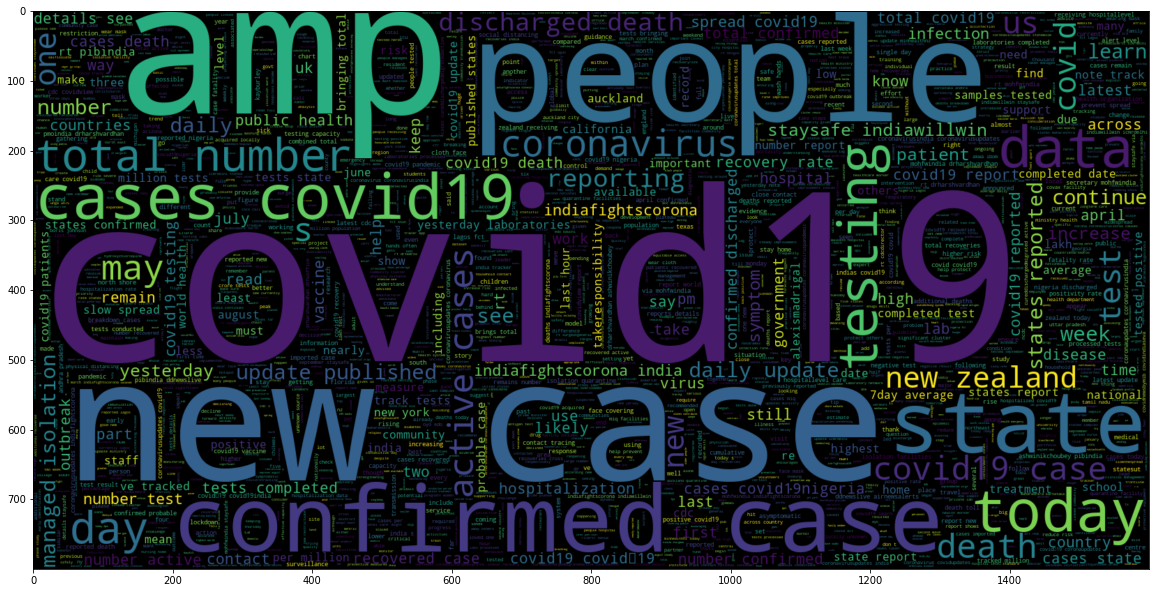

In [44]:
## Conduct EDA and build wordclouds to see the most frequent words that occur in real vs fake tweets 
## using preprocessed reviews
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(x_train[x_train.label == 'real'].cleaned_tweet))
plt.imshow(wc, interpolation = 'bilinear')

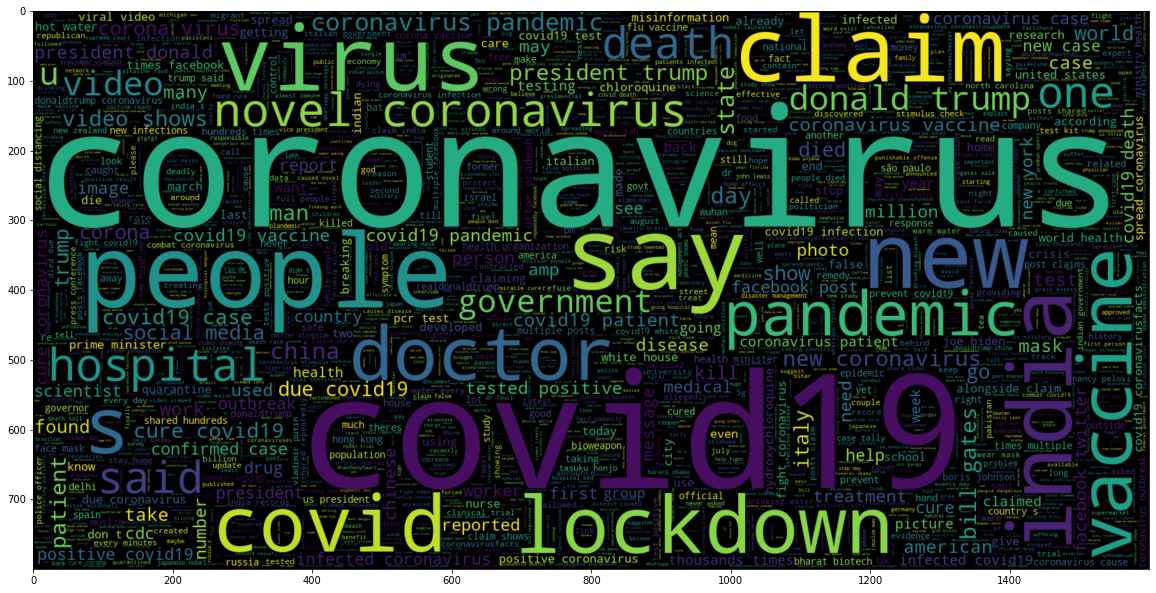

In [45]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(x_train[x_train.label == 'fake'].cleaned_tweet))
plt.imshow(wc, interpolation = 'bilinear')

In [46]:
## Create Bag of Words preprocessed datasets
from sklearn.feature_extraction.text import CountVectorizer

corpus1 = x_train['tweet'].values.tolist()
corpus2 = x_train['tweet'].values.tolist()
corpus1_val = x_val['tweet'].values.tolist()
corpus2_val = x_val['tweet'].values.tolist()


# Lemmatized One-hot Encoding
vectorizer = CountVectorizer(binary = True, preprocessor= lemmatize_preprocessed_news)
x_lemmatized_ohe = vectorizer.fit_transform(corpus1).toarray()
x_lemmatized_ohe_val = vectorizer.transform(corpus1_val).toarray()


# Stemmed One-hot Encoding
x_stemmed_ohe = vectorizer.fit_transform(corpus2).toarray()
x_stemmed_ohe_val = vectorizer.transform(corpus2_val).toarray()


# Lemmatized Bag of Words
vectorizer = CountVectorizer(preprocessor= lemmatize_preprocessed_news)
x_lemmatized_bow = vectorizer.fit_transform(corpus1).toarray()
x_lemmatized_bow_val = vectorizer.transform(corpus1_val).toarray()


# Stemmed Bag of Words
vectorizer = CountVectorizer(preprocessor=stemmed_preprocessed_news)
x_stemmed_bow = vectorizer.fit_transform(corpus2).toarray()
x_stemmed_bow_val = vectorizer.transform(corpus2_val).toarray()



In [47]:
## Create TFIDF preprocessed datasets
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(preprocessor = lemmatize_preprocessed_news)
x_lemmatized_tfidf = vectorizer.fit_transform(corpus1).toarray()
x_lemmatized_tfidf_val = vectorizer.transform(corpus1_val).toarray()

vectorizer = TfidfVectorizer(preprocessor=stemmed_preprocessed_news)
x_stemmed_tfidf = vectorizer.fit_transform(corpus2).toarray()
x_stemmed_tfidf_val = vectorizer.transform(corpus2_val).toarray()


In [48]:
pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
def create_w2vec_vectors(model, train, val):
  words = set(model.wv.index_to_key)
  x_train = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in train])
  x_val = np.array([np.array([model.wv[i] for i in ls if i in words]) for ls in val])
  

  x_train_avg = []
  for i in x_train:
    if i.size:
      x_train_avg.append(i.mean(axis=0))
    else:
        x_train_avg.append(np.zeros(100, dtype=float))

  x_val_avg = []
  for i in x_val:
    if i.size:
      x_val_avg.append(i.mean(axis=0))
    else:
        x_val_avg.append(np.zeros(100, dtype=float))

  return x_train_avg, x_val_avg


In [50]:
## Create Word2Vec vectors
import itertools
import gensim
from gensim.models import Word2Vec
lemmatized_tokns = list(x_train['lemmatized_tokens'])
lemmatized_token_list = list(itertools.chain(*lemmatized_tokns))

CBOW = gensim.models.Word2Vec([lemmatized_token_list], window =5, min_count=1, workers = 4)
SG = gensim.models.Word2Vec([lemmatized_token_list], window =5, min_count=1, workers = 4, sg=1)

#x_train['lemmatized_tokens'].values

#lemmatized_train_CBOW, lemmatized_val_CBOW, lemmatized_test_CBOW = 
lemmatized_train_CBOW, lemmatized_val_CBOW = create_w2vec_vectors(CBOW, x_train['lemmatized_tokens'].values, x_val['lemmatized_tokens'].values)

lemmatized_train_SG, lemmatized_val_SG = create_w2vec_vectors(SG, x_train["lemmatized_tokens"].values, x_val["lemmatized_tokens"].values)



stemmed_tokens = list(x_train['stemmed_tokens'])
stemmed_token_list = list(itertools.chain(*stemmed_tokens))
CBOW = gensim.models.Word2Vec([stemmed_token_list], window =5, min_count=1, workers = 4)
SG = gensim.models.Word2Vec([stemmed_token_list], window =5, min_count=1, workers = 4, sg=1)

stemmed_train_CBOW, stemmed_val_CBOW = create_w2vec_vectors(CBOW, x_train["stemmed_tokens"].values, x_val["stemmed_tokens"].values)

stemmed_train_SG, stemmed_val_SG = create_w2vec_vectors(SG, x_train["stemmed_tokens"].values, x_val["stemmed_tokens"].values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
def plot_confusion_matrix(y_true, y_pred):
  cf_matrix = confusion_matrix(y_true, y_pred)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
  return

In [ ]:
#plot precision recall score
from sklearn.metrics import precision_recall_curve
def plot_precision_recall(y_test, y_score):
  precision, recall, thresholds = precision_recall_curve(y_test, y_score)
  fig, ax = plt.subplots()
  ax.plot(recall, precision, color='purple')
  ax.set_title('Precision-Recall Curve')
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')
  plt.show()

In [ ]:
## Obtain total number of words present in lemmatized reviews
list_of_words = []
for i in x_train.lemmatized_tweet:
    for j in i:
        list_of_words.append(j)
        
total_words_lemmatized_news = len(list(set(list_of_words)))

In [ ]:
## Obtain total number of words present in stemmed reviews
list_of_words = []
for i in x_train.stemmed_tweet:
    for j in i:
        list_of_words.append(j)
        
total_words_stemmed_news = len(list(set(list_of_words)))

PASSIVE AGGRESSIVE CLASSIFIER

BoW model on a plain classifier

In [63]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

model_PA = PassiveAggressiveClassifier(C = 0.5, random_state = 5)
model_PA.fit(lemmatized_train_CBOW, y_train.ravel())
val_pred_PA_bow = model_PA.predict(lemmatized_val_CBOW)
val_pred_PA_bow

array([1, 1, 1, ..., 1, 1, 0])

In [64]:
from sklearn.metrics import f1_score
y_train_pred_bow_PA=model_PA.predict(lemmatized_train_CBOW)
f1_score(y_train,y_train_pred_bow_PA)

0.7475259473811249

In [65]:
f1_score(y_val,val_pred_PA_bow)

0.7314516129032258

In [66]:
accuracy_score(y_train,y_train_pred_bow_PA)

0.6886904761904762

In [67]:
accuracy_score(y_val,val_pred_PA_bow)

0.688785046728972

In [68]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train,y_train_pred_bow_PA)

0.6287048315062932

In [69]:
precision_score(y_val,val_pred_PA_bow)

0.6212328767123287

In [70]:
recall_score(y_train,y_train_pred_bow_PA)

0.9217261904761904

In [71]:
recall_score(y_val,val_pred_PA_bow)

0.8892156862745098

In [72]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train,y_train_pred_bow_PA)

0.6886904761904762

In [73]:
roc_auc_score(y_val,val_pred_PA_bow)

0.6977328431372548

BoW grid search Passive Aggressive Classifier

PA Classifer stem

In [74]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

model_PA = PassiveAggressiveClassifier(C = 0.5, random_state = 5)
model_PA.fit(lemmatized_train_SG, y_train.ravel())
val_pred_PA_bow = model_PA.predict(lemmatized_val_SG)
val_pred_PA_bow

array([1, 0, 1, ..., 1, 0, 0])

In [75]:
from sklearn.metrics import f1_score
y_train_pred_bow_PA=model_PA.predict(lemmatized_train_SG)
f1_score(y_train,y_train_pred_bow_PA)

0.7696523871339969

In [76]:
f1_score(y_val,val_pred_PA_bow)

0.7337630143777889

In [77]:
accuracy_score(y_train,y_train_pred_bow_PA)

0.7623511904761905

In [78]:
accuracy_score(y_val,val_pred_PA_bow)

0.7490654205607477

In [79]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train,y_train_pred_bow_PA)

0.7467114469633361

In [80]:
precision_score(y_val,val_pred_PA_bow)

0.7422266800401204

In [81]:
recall_score(y_train,y_train_pred_bow_PA)

0.794047619047619

In [82]:
recall_score(y_val,val_pred_PA_bow)

0.7254901960784313

In [83]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train,y_train_pred_bow_PA)

0.7623511904761904

In [84]:
roc_auc_score(y_val,val_pred_PA_bow)

0.7480129551820729

ADABOOST

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
model_AB = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None))
model_AB.fit(lemmatized_train_SG, y_train)

val_pred_AB_bow = model_AB.predict(lemmatized_val_SG)
val_pred_AB_bow

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, ..., 0, 0, 0])

In [89]:

y_train_pred_bow_AB=model_AB.predict(lemmatized_train_SG)
f1_score(y_train,y_train_pred_bow_AB)

1.0

In [90]:
f1_score(y_val,val_pred_AB_bow)

0.647374062165059

In [91]:
accuracy_score(y_train,y_train_pred_bow_AB)

1.0

In [92]:
accuracy_score(y_val,val_pred_AB_bow)

0.6925233644859813

In [94]:

precision_score(y_train,y_train_pred_bow_AB)

1.0

In [95]:
precision_score(y_val,val_pred_AB_bow)

0.7139479905437353

In [96]:
recall_score(y_train,y_train_pred_bow_AB)

1.0

In [97]:
recall_score(y_val,val_pred_AB_bow)

0.592156862745098

In [98]:

roc_auc_score(y_train,y_train_pred_bow_AB)

1.0

In [99]:
roc_auc_score(y_val,val_pred_AB_bow)

0.6880427170868348

In [100]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
model_AB = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None))
model_AB.fit(lemmatized_train_CBOW, y_train)

val_pred_AB_bow = model_AB.predict(lemmatized_val_CBOW)
val_pred_AB_bow

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, ..., 1, 1, 0])

In [101]:

y_train_pred_bow_AB=model_AB.predict(lemmatized_train_CBOW)
f1_score(y_train,y_train_pred_bow_AB)

1.0

In [102]:
f1_score(y_val,val_pred_AB_bow)

0.6518046709129512

In [103]:
accuracy_score(y_train,y_train_pred_bow_AB)

1.0

In [104]:
accuracy_score(y_val,val_pred_AB_bow)

0.6934579439252336

In [105]:

precision_score(y_train,y_train_pred_bow_AB)

1.0

In [106]:
precision_score(y_val,val_pred_AB_bow)

0.7106481481481481

In [107]:
recall_score(y_train,y_train_pred_bow_AB)

1.0

In [108]:
recall_score(y_val,val_pred_AB_bow)

0.6019607843137255

In [109]:

roc_auc_score(y_train,y_train_pred_bow_AB)

1.0

In [110]:
roc_auc_score(y_val,val_pred_AB_bow)

0.68937324929972